<a href="https://colab.research.google.com/github/sydney-machine-learning/sentimentanalysis-USelections/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext google.colab.data_table

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install langdetect
!pip install geopandas

     |████████████████████████████████| 983kB 9.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=d305b71be8719f39bc40ba08756bcdc4435a04fc789604d8fd571d6043aa4560
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████████████████| 972kB 7.8MB/s 
     |████████████████████████████████| 14.8MB 200kB/s 
     |████████████████████████████████| 6.5MB 48.4MB/s 


In [4]:
import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata

%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# **Initial EDA**

## 1. Trump

In [5]:
df1=pd.read_csv('/content/drive/MyDrive/US_elections/hashtag_donaldtrump.csv', lineterminator='\n')
df1.head(2)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530


## Biden

In [6]:
df2=pd.read_csv('/content/drive/MyDrive/US_elections/hashtag_joebiden.csv', lineterminator='\n')
df2.head(2)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,809904438.0,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283


# 2. Further EDA

In [7]:
# Reading both the csv files
tweets_biden = pd.read_csv('/content/drive/MyDrive/US_elections/hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
tweets_trump = pd.read_csv('/content/drive/MyDrive/US_elections/hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)

# Replace United states in country column with USA full form
tweets_biden['country'].replace({'United States':'United States of America'}, inplace=True)
tweets_trump['country'].replace({'United States':'United States of America'}, inplace=True)


# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

# convert to datetime object
tweets_biden['user_join_date']=pd.to_datetime(tweets_biden['user_join_date'])
tweets_trump['user_join_date']=pd.to_datetime(tweets_trump['user_join_date'])
tweets_biden['collected_at']=pd.to_datetime(tweets_biden['collected_at'])
tweets_trump['collected_at']=pd.to_datetime(tweets_trump['collected_at'])
tweets_biden['created_at']=pd.to_datetime(tweets_biden['created_at'])
tweets_trump['created_at']=pd.to_datetime(tweets_trump['created_at'])

# create additional date time columns
tweets_biden['created_at_r']=tweets_biden['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump['created_at_r']=tweets_trump['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_biden['created_at_r2']=tweets_biden['created_at'].dt.strftime('%m-%d')
tweets_trump['created_at_r2']=tweets_trump['created_at'].dt.strftime('%m-%d')

# normalise time diff to hours
b_tdiff=(tweets_biden['collected_at'] - tweets_biden['created_at'])
t_tdiff=(tweets_trump['collected_at'] - tweets_trump['created_at'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

# Use numpy vectorisation to create new columns for normalised likes and retweets
tweets_biden['likes_norm'] = normalise(tweets_biden['likes'],b_tdiff)
tweets_biden['retweet_norm'] = normalise(tweets_biden['retweet_count'],b_tdiff)
tweets_trump['likes_norm'] = normalise(tweets_trump['likes'],t_tdiff)
tweets_trump['retweet_norm'] = normalise(tweets_trump['retweet_count'],t_tdiff)

tweets_biden.tail(2)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,created_at_r,created_at_r2,likes_norm,retweet_norm
776884,2020-11-08 23:59:52,1.325589e+18,🌎\n\n“#congiuntifuoriregione”\n\n‘Sono felice ...,1.0,1.0,Twitter for iPhone,529331509.0,Angelo Tani,AngeloTani,nato a casa dei nonni,2012-03-19 12:07:06,5974.0,🌎,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.599846,2020-11-08 23,11-08,0.053914,0.053914
776885,2020-11-08 23:59:58,1.325589e+18,"Ik moet zeggen dat ik #Biden ""the lesser of tw...",0.0,0.0,Twitter for Android,586386345.0,Job,_JobO__,-voeg hier uw interessante bio toe-,2012-05-21 06:30:14,119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.747707,2020-11-08 23,11-08,0.000000,0.000000


In [8]:
# Visualisation functions
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

## Null Values analysis

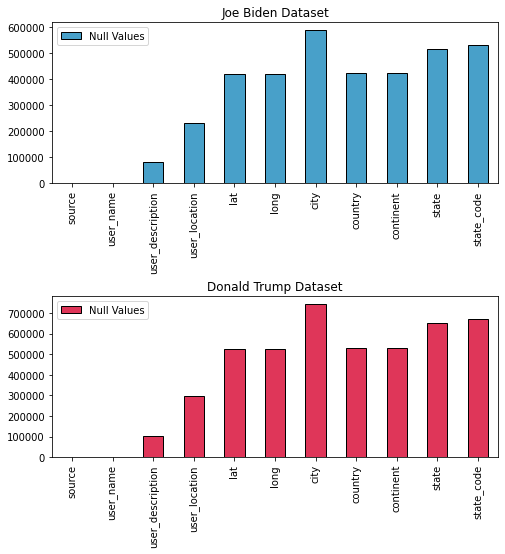

In [9]:
na_vals_b=pd.DataFrame({'Null Values':tweets_biden.isna().sum()})
na_vals_b=na_vals_b.loc[na_vals_b['Null Values'] > 0]
na_vals_t=pd.DataFrame({'Null Values':tweets_trump.isna().sum()})
na_vals_t=na_vals_t.loc[na_vals_t['Null Values'] > 0]

# Null values visualisation for tweets about Joe Biden and Donald Trump
fig, ax=plt.subplots(2,1, figsize=(8,8), gridspec_kw={'hspace':0.7})

na_vals_b.plot.bar(color=barcolors[3], **barstyle, ax=ax[0])
ax[0].set_title('Joe Biden Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

na_vals_t.plot.bar(color=barcolors[6], **barstyle, ax=ax[1])
ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()

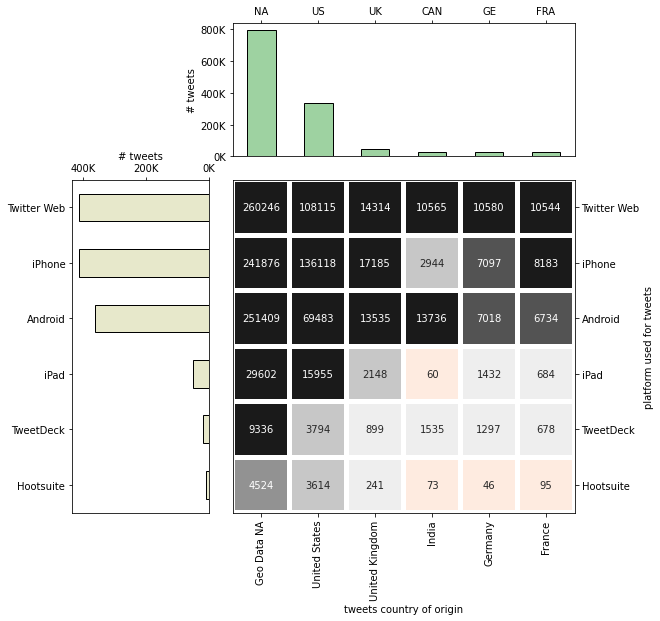

In [10]:
# Code taken from https://www.kaggle.com/tkubacka/a-story-told-through-a-heatmap

source_df=pd.concat([tweets_biden[['source','tweet','country']].copy(),tweets_trump[['source','tweet','country']].copy()])
source_df['country'].replace({'United States of America':'United States'}, inplace=True)
source_df=source_df.fillna('Geo Data NA')
source_df=source_df.drop_duplicates()

sources=pd.DataFrame(source_df.groupby(['source'])['tweet'].count().sort_values(ascending=False)[:6])
sources=sources.reset_index()
sourceslst=sources.source.to_list()

country=pd.DataFrame(source_df.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:6])
country=country.reset_index()
countrylst=country.country.to_list()

platXtab=pd.DataFrame(source_df.groupby(['source','country'])['tweet'].count().unstack().fillna(0))

fig, ax=plt.subplots(2,2, figsize=(9,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap1(platXtab.loc[sourceslst,countrylst], hm_ax)
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('platform used for tweets')
hm_ax.set_yticklabels(('Twitter Web','iPhone','Android','iPad','TweetDeck','Hootsuite'), rotation=0) 

bar_ax = ax[0,1]
platXtab.loc[sourceslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_xticklabels(('NA', 'US', 'UK', 'CAN', 'GE','FRA'), rotation=0) 
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# tweets')

barh_ax = ax[1,0]
platXtab.loc[sourceslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[2],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_yticklabels(('Hootsuite','TweetDeck','iPad','Android','iPhone','Twitter Web'), rotation=0) 
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')
plt.show()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


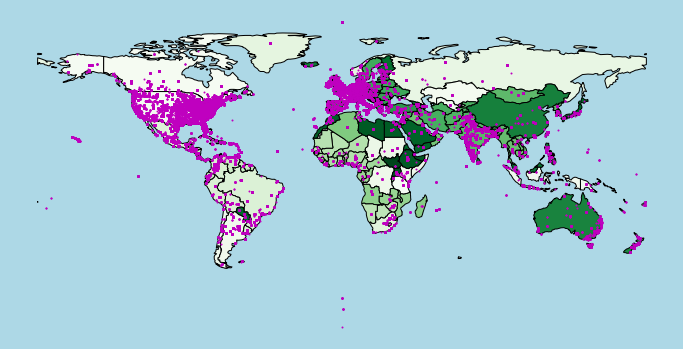

In [11]:
world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from shapely.geometry import Point, Polygon
crs = {'init': 'EPSG:4326'}

tmp=pd.concat([tweets_biden[['lat','long']].copy(),tweets_trump[['lat','long']].copy()])
tmp=tmp.dropna()
geometry = [Point(xy) for xy in zip(tmp['long'],tmp['lat'])]
geo_df=gpd.GeoDataFrame(tmp, crs=crs, geometry = geometry)


# Comment out this code if you have visualized the result
fig, ax = plt.subplots(1,figsize=(12,12), facecolor='lightblue')
world = world[world.name != "Antarctica"]
world.plot(ax=ax, cmap='Greens', edgecolors='black')
geo_df.plot(ax=ax, markersize=1, color='m', marker='o')
ax.axis('off')
plt.show()

In [12]:
%%time
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine two data files and drop duplicates
lang_df=pd.concat([tweets_biden[['tweet','country']].copy(),tweets_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge analysis
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)

# Select top five languages and five countries for heatmap
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)

CPU times: user 31.9 s, sys: 240 ms, total: 32.2 s
Wall time: 32.2 s


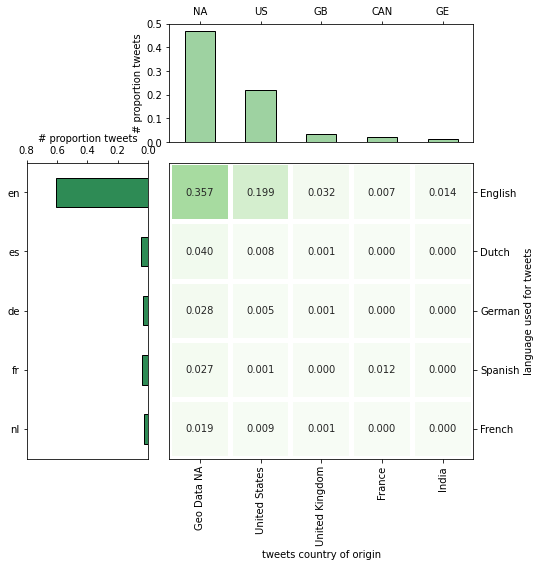

In [13]:
fig, ax=plt.subplots(2,2, figsize=(8,8), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap2(langXtab.loc[langslst,countrylst], hm_ax)
hm_ax.set_yticklabels(('English', 'Dutch', 'German','Spanish','French'), rotation=0) 
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('language used for tweets')

bar_ax = ax[0,1]
langXtab.loc[langslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.set_xticklabels(('NA','US', 'GB', 'CAN', 'GE', 'FRA'), rotation=0) 
bar_ax.set_ylim([0, 0.5])
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# proportion tweets')

barh_ax = ax[1,0]
langXtab.loc[langslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[5],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlim([0.8, 0])
barh_ax.set_xlabel('# proportion tweets')
barh_ax.set_ylabel('')
barh_ax.set_yticklabels(langslst[::-1], rotation=0) 

plt.show()


In [14]:
# Identify the common UserId's in both datasets and create tables for feed visualisation
common_ids=np.intersect1d(tweets_biden.user_id, tweets_trump.user_id)
unique_b=tweets_biden[~tweets_biden.user_id.isin(common_ids)].copy()
common_b=tweets_biden[tweets_biden.user_id.isin(common_ids)].copy()
unique_t=tweets_trump[~tweets_trump.user_id.isin(common_ids)].copy()
common_t=tweets_trump[tweets_trump.user_id.isin(common_ids)].copy()

common_df=pd.concat([common_b,common_t])
common_df=common_df.drop_duplicates()

# Create columns for visualiation
unique_b['usertype'] = 'Biden'
unique_t['usertype'] = 'Trump'
common_df['usertype'] = 'Both'

# Narrow down data
cont_df=pd.concat([unique_b[['tweet','continent','usertype']].copy(),
                   unique_t[['tweet','continent','usertype']].copy(),
                   common_df[['tweet','continent','usertype']].copy()])

# Label NA Geo Data
cont_df=cont_df.fillna('Geo Data NA')

# Calculate tweet counts for each usertype and continuent
usertype=pd.DataFrame(cont_df.groupby(['usertype'])['tweet'].count().sort_values(ascending=False))
usertype=usertype.reset_index()
userlst=usertype.usertype.tolist()

continent=pd.DataFrame(cont_df.groupby(['continent'])['tweet'].count().sort_values(ascending=False)[:6])
continent=continent.reset_index()
contlst=continent.continent.to_list()

# Create crosstab to feed heatmap
contXtab=pd.crosstab(cont_df.continent, cont_df.usertype)

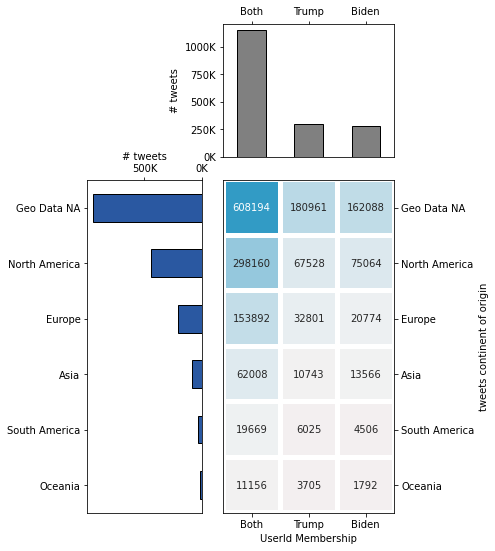

In [15]:
fig, ax=plt.subplots(2,2, figsize=(5.5,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,3], 'wspace':0.15, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap3(contXtab.loc[contlst,userlst], hm_ax)
hm_ax.set_xlabel('UserId Membership')
hm_ax.set_ylabel('tweets continent of origin')

bar_ax = ax[0,1]
contXtab.loc[contlst,userlst].sum().plot.bar(ax=bar_ax, color=barcolors[7],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_ylabel('# tweets')
bar_ax.set_xlabel('')

barh_ax = ax[1,0]
contXtab.loc[contlst,userlst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[4],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')

plt.show()

In [16]:
# Identify common tweet creation dates
common_creat=np.intersect1d(tweets_biden.created_at_r, tweets_trump.created_at_r)

# Mask out data to ensure common lenth arrays to feed visualisation
cnt_tbiden=tweets_biden[tweets_biden.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()
cnt_ttrump=tweets_trump[tweets_trump.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


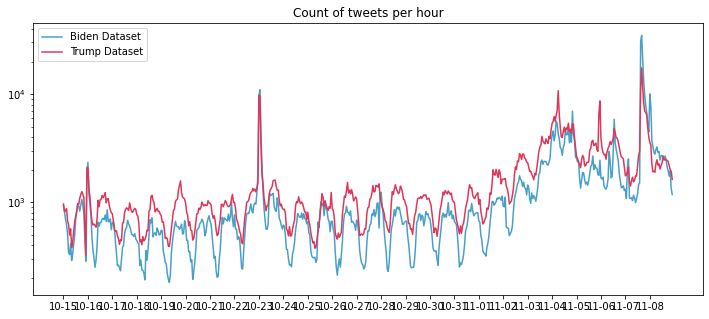

In [17]:
plt.figure(figsize=(12,5))
p6=sns.lineplot(cnt_tbiden.index, cnt_tbiden.values, color=barcolors[3], label='Biden Dataset')
p6.set_title('Count of tweets per hour')
p6=sns.lineplot(cnt_ttrump.index, cnt_ttrump.values, color=barcolors[6], label='Trump Dataset')
p6.set_xticks(range(0, len(cnt_tbiden.index), 24))
p6.set_xticklabels(common_df['created_at'].dt.strftime('%m-%d').unique().tolist())
p6.set_yscale('log')
plt.show()

In [18]:
# fig, ax=plt.subplots(1,1, figsize=(12,5))

# line_ax = ax
# line_ax.set_title('Distribution of Number of tweets posted by users')
# sns.kdeplot(tweets_biden.groupby(['user_id'])['tweet'].count(), shade=True, color='b', label='Biden Dataset', ax=line_ax)
# sns.kdeplot(tweets_trump.groupby(['user_id'])['tweet'].count(), shade=True, color='r', label='Trump Dataset', ax=line_ax)
# plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


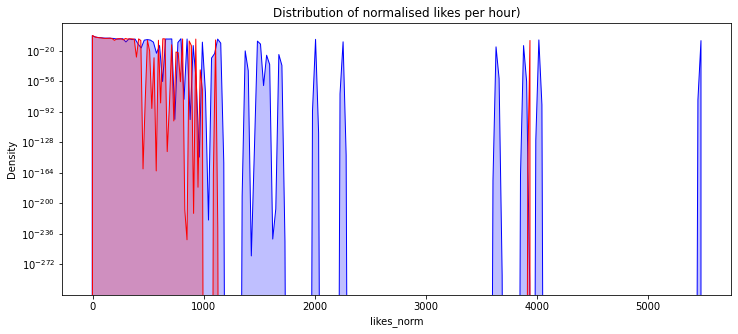

In [19]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Distribution of normalised likes per hour)')
sns.kdeplot(tweets_biden['likes_norm'],bw=0.1, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['likes_norm'],bw=0.1, shade=True, color='r', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


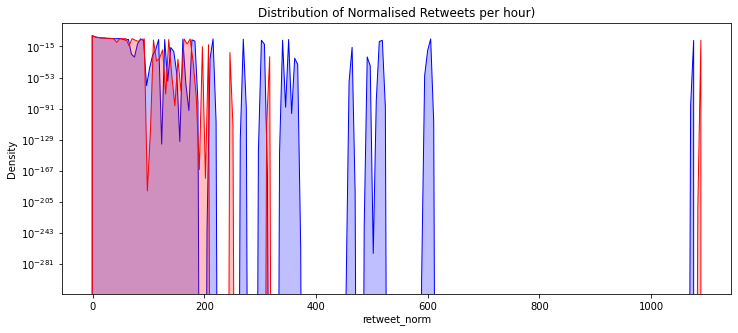

In [20]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Distribution of Normalised Retweets per hour)')
sns.kdeplot(tweets_biden['retweet_norm'],bw=0.1, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['retweet_norm'],bw=0.1, shade=True, color='r', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

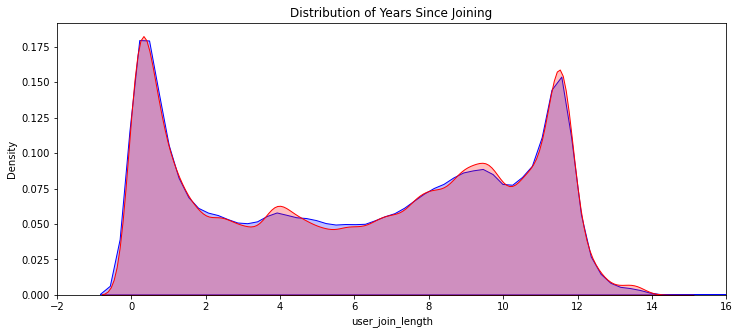

In [21]:
fig, ax=plt.subplots(1,1, figsize=(12,5))
tweets_biden['user_join_length'] = max(tweets_biden['created_at']) - tweets_biden['user_join_date']
tweets_trump['user_join_length'] = max(tweets_trump['created_at']) - tweets_trump['user_join_date']

line_ax = ax
plt.xlim(-2, 16)
line_ax.set_title('Distribution of Years Since Joining')
sns.kdeplot(tweets_biden['user_join_length'].dt.days/365.25, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['user_join_length'].dt.days/365.25, shade=True, color='r', label='Trump Dataset', ax=line_ax)
plt.show()

# Let's jump to the training part after little data cleaning

Obtain tweets only from data that has Geo Data from the US

In [22]:

text1=tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']

## DATA CLEANING

Clean the tweets to remove stopwords, strings with "http" etc and then lemmatize the words using python's NLP toolkit

In [23]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [24]:
def clean1(sent):
    filtered_sent=""
    stopwords = nltk.corpus.stopwords.words('english')
    sent = (unicodedata.normalize('NFKD', sent)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    sent = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',sent)
    words=sent.split()
    for word in words:
        if word not in stopwords:
            filtered_sent=filtered_sent+' '+word
    return filtered_sent

def clean2(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', ' ', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

words1 = clean2(''.join(str(text1.apply(clean1).tolist())))
words2 = clean2(''.join(str(text2.apply(clean1).tolist())))
words1[:10]

['islandgirlprv',
 'bradbeauregardj',
 'meidastouch',
 'ccp',
 'thats',
 'always',
 'fine',
 'jack',
 'vijaya',
 'dickc']

## top 10 bi and tri Ngrams from cleaned data

In [25]:
biden_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
trump_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
biden_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
trump_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Input Bi and Tri Ngrams into dataframes for plotting
biden_ngrams=pd.concat([biden_2ngrams,biden_3ngrams])
trump_ngrams=pd.concat([trump_2ngrams,trump_3ngrams])


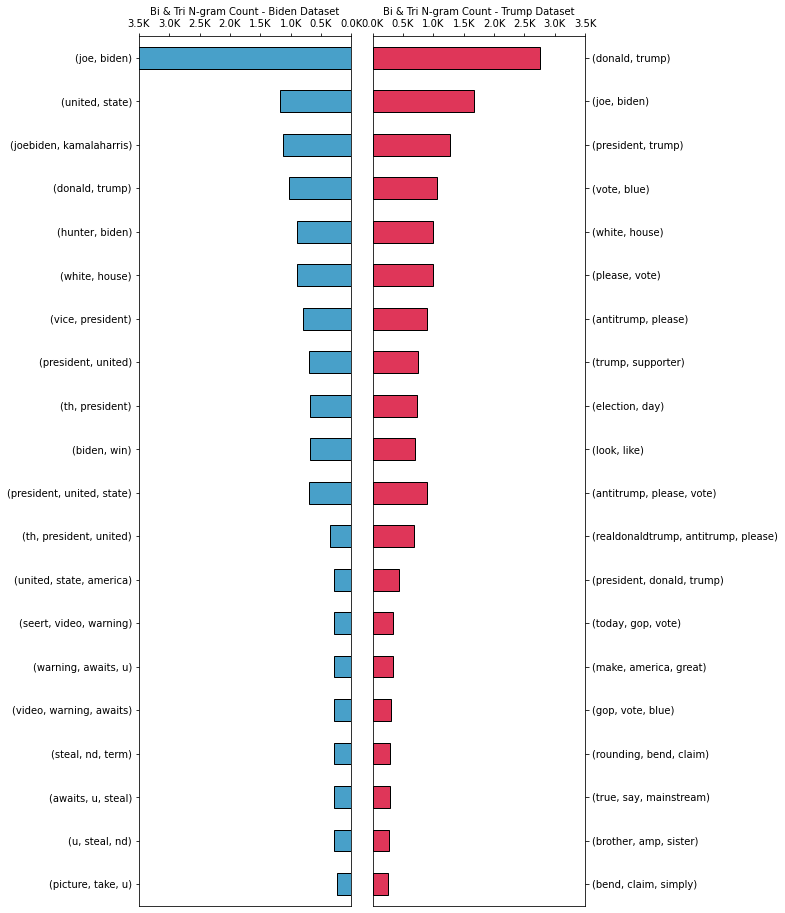

In [26]:
fig, ax=plt.subplots(1,2, figsize=(8,16), 
                     gridspec_kw={'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
biden_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('Bi & Tri N-gram Count - Biden Dataset')
barh_ax.set_ylabel('')

barh_ax = ax[1]
trump_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_xlabel('Bi & Tri N-gram Count - Trump Dataset')
barh_ax.set_ylabel('')
plt.show()

The above graph shows the most common Bi and Tri N-gram's in each of the respective datasets, filtered from words just from the "United States of America". The N-gram's show a clear relation to the upcoming election and each respective dataset seems to be related to each of the presidential candidates.

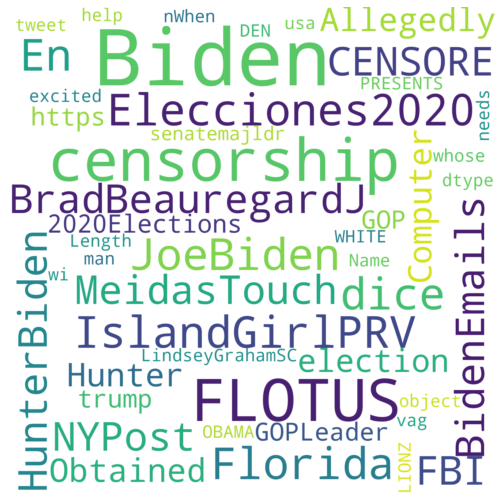

In [27]:
plt.subplots(1,1, figsize=(9,9))
wc_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="white", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_b.generate(str(text1.dropna()))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.show()

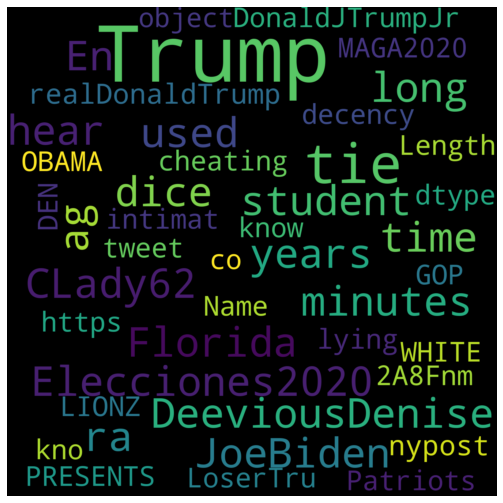

In [28]:
plt.subplots(1,1, figsize=(9,9))
wc_t = WordCloud(stopwords=STOPWORDS, 
                 background_color="black", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_t.generate(str(text2.dropna()))
plt.imshow(wc_t, interpolation="bilinear")
plt.axis('off')
plt.show()

#Cleaning Samples & Data Manipulation (Don't run this again if using mode=100)

In [5]:
trump_df_init = pd.read_csv('/content/drive/MyDrive/US_elections/hashtag_joebiden.csv', lineterminator='\n')
biden_df_init = pd.read_csv('/content/drive/MyDrive/US_elections/hashtag_donaldtrump.csv', lineterminator='\n')

In [6]:
biden_df = biden_df_init[biden_df_init['country'] == 'United States of America'].copy()
trump_df = trump_df_init[trump_df_init['country'] == 'United States of America'].copy()

In [7]:
biden_df.loc[:,'who'] = 'biden'
trump_df.loc[:,'who'] = 'trump'
data = pd.concat([biden_df, trump_df])

In [8]:
def _calculate_languages_ratios(text):
    languages_ratios = {}

    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens]

    # Compute per language included in nltk number of unique stopwords appearing in analyzed text
    for language in stopwords.fileids():
        stopwords_set = set(stopwords.words(language))
        words_set = set(words)
        common_elements = words_set.intersection(stopwords_set)

        languages_ratios[language] = len(common_elements) # language "score"

    return languages_ratios

def detect_language(text):
    ratios = _calculate_languages_ratios(text)

    most_rated_language = max(ratios, key=ratios.get)

    return most_rated_language

In [9]:
import sys, os
import re
from tqdm.auto import tqdm
from nltk import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords


import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:


def filter_english_one_to_one(df, who):
    tweets = df.query(f'who == "{who}" and state_code == state_code').sort_values('user_followers_count',ascending=False).drop_duplicates(['user_name'])[['tweet','long','lat','state_code']]
    languages = [detect_language(val) for val in tqdm(tweets.tweet)]
    filtered = tweets.loc[np.array(languages) == 'english']
    return filtered

def filter_english_sample_100(df, who):
    tweets = df.query(f'who == "{who}" and state_code == state_code').sort_values('user_followers_count',ascending=False)[['user_id','tweet','long','lat','state_code']]
    tweets = tweets.groupby("user_id").apply(
        lambda group_df: group_df.sample(100) if len(group_df) > 100 else group_df
    ).reset_index(drop=True)
    languages = [detect_language(val) for val in tqdm(tweets.tweet)]
    filtered = tweets.loc[np.array(languages) == 'english']
    return filtered

In [11]:
# filt_biden_df = filter_english_one_to_one(data, 'biden')
# filt_trump_df = filter_english_one_to_one(data, 'trump')

filt_biden_df = filter_english_sample_100(data, 'biden')
filt_trump_df = filter_english_sample_100(data, 'trump')

In [12]:

def tweet_clean_up(df):
    remove_links = lambda txt: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', txt)
    remove_special = lambda txt: re.sub(r'[^a-zA-Z0-9!,.\'\"\?\-\s]', '', txt)
    remove_newline = lambda txt: re.sub(r'\n', ' ', txt)
    df['tweet'] = df['tweet'].apply(lambda x: remove_newline(remove_special(remove_links(x))))
    return df

In [13]:
cleaned_biden = tweet_clean_up(filt_biden_df)
cleaned_trump = tweet_clean_up(filt_trump_df)

In [14]:
cleaned_biden.loc[:,'sentiment'] = 0
cleaned_trump.loc[:,'sentiment'] = 0

In [17]:
cleaned_biden.to_csv('/content/drive/MyDrive/US_elections/cleaned_sample_100_biden.csv', index=False, header=True)
cleaned_trump.to_csv('/content/drive/MyDrive/US_elections/cleaned_sample_100_trump.csv', index=False, header=True)

# Berth fine tuning

In [25]:
import tensorflow as tf
import pandas as pd

hysical_devices = tf.config.list_physical_devices('GPU')
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [28]:

URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

84131840/84125825 [==============================] - 1s 0us/step


In [29]:
# The shutil module offers a number of high-level 
# operations on files and collections of files.
import os
import shutil
# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsup folder since this is a supervised learning task
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
# View the final train folder
print(os.listdir(train_dir))

['pos', 'neg', 'urls_unsup.txt', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'unsupBow.feat']


In [30]:
# We create a training dataset and a validation 
# dataset from our "aclImdb/train" directory with a 80/20 split.
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [31]:
for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,Canadian director Vincenzo Natali took the art...,1
1,I gave this film 10 not because it is a superb...,1
2,I admit to being somewhat jaded about the movi...,1
3,"For a long time, 'The Menagerie' was my favori...",1
4,A truly frightening film. Feels as if it were ...,0


In [32]:

for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test['DATA_COLUMN'] = test['DATA_COLUMN'].str.decode("utf-8")
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,I can't believe that so much talent can be was...,0
1,This movie blows - let's get that straight rig...,0
2,"The saddest thing about this ""tribute"" is that...",0
3,I'm only rating this film as a 3 out of pity b...,0
4,Something surprised me about this movie - it w...,1


In [33]:

InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [34]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [35]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(16).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(16)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=1, validation_data=validation_data)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


   2500/Unknown - 1146s 451ms/step - loss: 0.1192 - accuracy: 0.9558

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2500/2500 [==============================] - 1194s 470ms/step - loss: 0.1192 - accuracy: 0.9558 - val_loss: 0.4444 - val_accuracy: 0.8816


In [ ]:
# model.fit(train_data, epochs=1, validation_data=validation_data)

In [40]:
model.save(f'/content/drive/MyDrive/US_elections/bert_emo_finetuned')

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
T

INFO:tensorflow:Assets written to: /content/drive/MyDrive/US_elections/bert_emo_finetuned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/US_elections/bert_emo_finetuned/assets


# Load saved model


In [41]:
finetuned_bert = tf.keras.models.load_model('/content/drive/MyDrive/US_elections/bert_emo_finetuned')

In [45]:
finetuned_bert.save_weights('/content/drive/MyDrive/US_elections/test.h5')

In [46]:
model.load_weights('/content/drive/MyDrive/US_elections/test.h5')

In [47]:
pred_sentences = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
                  'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']

In [48]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])

This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good : 
 Positive
One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie : 
 Negative


# Emotion classifier (Don't run this again)

In [49]:
from transformers import BertTokenizer, TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
model.load_weights('/content/drive/MyDrive/US_elections/test.h5')

In [51]:
biden_df = pd.read_csv('/content/drive/MyDrive/US_elections/cleaned_sample_100_biden.csv')
trump_df = pd.read_csv('/content/drive/MyDrive/US_elections/cleaned_sample_100_trump.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
biden_df.loc[:,'who'] = 'biden'
trump_df.loc[:,'who'] = 'trump'

balance_data_df = pd.DataFrame(columns=biden_df.columns)

balance_data_df

,user_id,tweet,long,lat,state_code,sentiment,who


In [54]:
states_list = set(biden_df['state_code']).union(set(trump_df['state_code'])) - set(['MP', 'GU', 'PR', 'VI', 'AS', 'UM', ])

In [55]:
for state in states_list:
    trump_df_state = trump_df[trump_df['state_code']==state]
    biden_df_state = biden_df[biden_df['state_code']==state]
    
    n_sample = len(trump_df_state) if len(trump_df_state) < len(biden_df_state) else len(biden_df_state)
    
    if len(trump_df_state) < len(biden_df_state):
        balance_data_df = pd.concat([balance_data_df, trump_df_state])
        balance_data_df = pd.concat([balance_data_df, biden_df_state.sample(len(trump_df_state))])
    else:
        balance_data_df = pd.concat([balance_data_df, biden_df_state])
        balance_data_df = pd.concat([balance_data_df, trump_df_state.sample(len(biden_df_state))])

In [56]:
balance_data_df

,user_id,tweet,long,lat,state_code,sentiment,who
1389,14097287.0,Biden,-157.8556764,21.3045,HI,0.0,trump
1390,14097287.0,Biden,-157.8556764,21.3045,HI,0.0,trump
1391,14097287.0,Biden,-157.8556764,21.3045,HI,0.0,trump
1392,14097287.0,Biden,-157.8556764,21.3045,HI,0.0,trump
1418,14115192.0,QAnnon Karens from the Trump Cult are like Tr...,-156.31068330000005,20.803,HI,0.0,trump
...,...,...,...,...,...,...,...
119221,8.970796606846853e+17,"""In a shocking turnaround, 61.48 of the 109 Mu...",-71.59923719999998,41.7962,RI,0.0,biden
113293,8.108188006271754e+17,CNN forced to walk through Trump rally roulett...,-71.59923719999998,41.7962,RI,0.0,biden
397846,1.2326864800799048e+18,Trump Supporters in RhodeIsland !! Tuesday No...,-71.5992,41.7962409,RI,0.0,biden
110361,7.732914436622582e+17,thegoodgodabove The US government sued Trump f...,-71.4128343,41.824,RI,0.0,biden


In [57]:
batch_size = 100

In [58]:
def emotion_classify(tweet_list):
    batch_idx = np.append(np.arange(0, len(tweet_list), batch_size), len(tweet_list))
    labels = np.array([])
    for i in tqdm(range(len(batch_idx)-1)):
        tf_batch = tokenizer(tweet_list[batch_idx[i]:batch_idx[i+1]], max_length=280, padding=True, truncation=True, return_tensors='tf')
        tf_outputs = model(tf_batch)
        tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
        labels = np.append(labels, tf.argmax(tf_predictions, axis=1))
#         labels = np.append(labels, tf_predictions[:,1])
        del tf_batch
    return labels

In [59]:
balance_data_df['sentiment'] = emotion_classify(list(balance_data_df['tweet']))

In [60]:
len(states_list)

53

In [61]:
dem_states = set(['DC', 'VT', 'HI', 'MA', 'MD', 'CA', 'NY', 'RI', 'DE', 
                 'CT', 'WA', 'ME', 'NJ', 'OR', 'IL'])
rep_states = set(['OH', 'IA', 'TX', 'MT', 'SC', 'AK', 'MO', 'IN', 'NE',
                 'KS', 'UT', 'MS', 'TN', 'SD', 'KY', 'LA', 'AL', 'ND',
                 'ID', 'AR', 'OK', 'WV', 'WY'])
swing_states = states_list - dem_states - rep_states

In [62]:
swing_states

{'0',
 'AZ',
 'CO',
 'FL',
 'GA',
 'MI',
 'MN',
 'NC',
 'NH',
 'NM',
 'NV',
 'PA',
 'VA',
 'WI',
 nan}

In [63]:
electoral_vote_by_state = pd.read_csv('/content/drive/MyDrive/US_elections/electoral_vote_by_state.csv')

In [64]:
states_results = pd.DataFrame(columns=['state_code', 'biden', 'trump', 'type', 'winner'])

In [65]:
states_results.loc[:,'state_code'] = electoral_vote_by_state['state_code']
states_results.loc[:,'e_vote'] = electoral_vote_by_state['e_vote']

In [66]:
type_vs_candidate = {'blue': 'biden', 'red': 'trump', 'purple': 'contentious'}
threshold = 1.15
for state in states_list:
    trump_slice = balance_data_df.query(f'state_code == "{state}" and who == "trump"')
    biden_slice = balance_data_df.query(f'state_code == "{state}" and who == "biden"')
    trump_score = np.sum(trump_slice['sentiment']) + 1
    biden_score = np.sum(biden_slice['sentiment']) + 1
    
    state_type = ''
    if state in dem_states:
        state_type = 'blue'
    elif state in rep_states:
        state_type = 'red'
    else:
        state_type = 'purple'
        
    winner = ''
    if len(trump_slice) + len(biden_slice) < 1000:
        winner = type_vs_candidate[state_type]
    else:
        if trump_score/biden_score > threshold:
            winner = 'trump'
        elif biden_score/trump_score > threshold:
            winner = 'biden'
        else:
            winner = 'contentious'
        
    states_results.loc[states_results['state_code'] == state, ['biden', 'trump', 'type', 'winner']] = \
        [biden_score, trump_score, state_type, winner]

In [67]:
states_results.query('type=="blue" and winner=="trump"')

,state_code,biden,trump,type,winner,e_vote
8,CA,14058,17076,blue,trump,55
9,NJ,2154,2517,blue,trump,14
13,NY,10431,12458,blue,trump,29
16,DC,3594,4326,blue,trump,3
23,OR,1107,1361,blue,trump,7
26,IL,2903,3602,blue,trump,20
40,MD,1123,1386,blue,trump,10
42,MA,2021,2488,blue,trump,11
43,WA,1143,1410,blue,trump,12


In [68]:
states_results.query('type=="red" and winner=="biden"')

,state_code,biden,trump,type,winner,e_vote


In [69]:
states_results.query('winner=="contentious"')

,state_code,biden,trump,type,winner,e_vote
0,AL,495,531,red,contentious,9
5,NV,1333,1508,purple,contentious,6
7,NH,159,189,purple,contentious,4
11,NM,272,306,purple,contentious,5
12,CT,539,608,blue,contentious,7
18,FL,6886,7753,purple,contentious,29
22,HI,344,385,blue,contentious,4
29,SC,604,690,red,contentious,9
32,KS,524,590,red,contentious,6
33,TN,1063,1206,red,contentious,11


In [70]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [71]:
us_shape = gpd.read_file('/content/drive/MyDrive/US_elections/us_shape/cb_2018_us_state_20m.shp')

In [72]:
us_shape = us_shape[['STUSPS', 'geometry']]

In [73]:
states_results_tmp = states_results.copy()

In [74]:
states_results_tmp = states_results_tmp.merge(us_shape, left_on='state_code', right_on='STUSPS')
states_results_tmp.drop(['STUSPS'], axis=1, inplace=True)

In [75]:
states_results_tmp = gpd.GeoDataFrame(states_results_tmp)

In [76]:
states_results_tmp.columns

Index(['state_code', 'biden', 'trump', 'type', 'winner', 'e_vote', 'geometry'], dtype='object')

[]

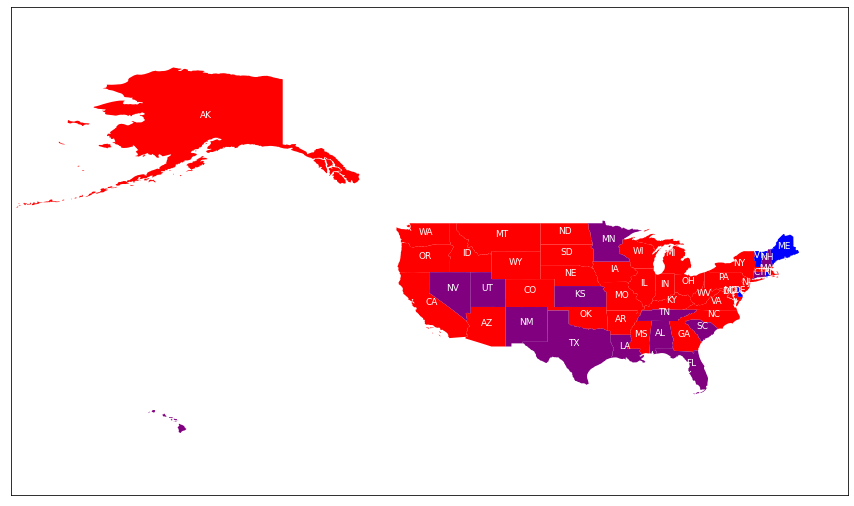

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
states_results_tmp.apply(lambda x: ax.annotate(s=x.state_code, xy=x.geometry.centroid.coords[0], ha='center', fontsize=9, color='white'),axis=1);
states_results_tmp[states_results_tmp['winner'] == 'trump'].plot(ax=ax, color='red')
states_results_tmp[states_results_tmp['winner'] == 'biden'].plot(ax=ax, color='blue')
states_results_tmp[states_results_tmp['winner'] == 'contentious'].plot(ax=ax, color='purple')
plt.axis('square')
ax.set_xlim([-180, -60])
ax.set_ylim([10, 80])
ax.set_xticks([])
ax.set_yticks([])

In [78]:
states_results.to_csv('/content/drive/MyDrive/US_elections/state_results_100_conti.csv', index=False, header=True)
fig.savefig('/content/drive/MyDrive/US_elections/state_results_100_conti.png')

In [79]:
trump_vote = np.sum(states_results[states_results['winner'] == 'trump']['e_vote'])
biden_vote = np.sum(states_results[states_results['winner'] == 'biden']['e_vote'])
print(trump_vote, biden_vote)

372 14
